In [1]:
tfile = '../out/gene_sets_tests.tsv'
gfile = '../out/SGRP2.tsv'
mfile = '../out/SGRP2-mutfunc.tsv'
ofile = '../out/go.txt'
cfile = '../out/complexes.cyc2008.txt'
pfile = '../out/reactome.txt'
kfile = '../out/modules.kegg.txt'
sfile = '../out/ko_scores.txt'
dfile = '../out/deviating.tsv'
sickness = '../data/sickness.tsv'
rdir = '../data/rnaseq/'
sgd = '../out/SGD_features.tab'
min_size = 2
max_size = 100

In [2]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

sns.set_style('white')

plt.rc('font', size=12)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
import os
import numpy as np
import pandas as pd

In [4]:
def load_gene_sets(go,
                   cpx,
                   path,
                   module,
                   min_size=min_size,
                   max_size=max_size):
    d = {}
    for f, name in zip([go, cpx,
                        path, module],
                       ['gos', 'complexes',
                        'pathways', 'modules']):
        d[name] = {x.rstrip().split()[0]: set(x.rstrip().split()[1].split(','))
                   for x in open(f)
                   if min_size <= len(set(x.rstrip().split()[1].split(','))) <= max_size}
    
    return d

In [5]:
def read_de_table(fname, 
                  f=None):
    if f is None:
        f = {}
    
    m = pd.read_table(fname,
                      sep=',',
                      index_col=0).dropna()
    m.index = [f.get(x, x) for x in m.index]
    pseudo = sorted([x for x in m['padj'].unique() if x != 0])[0]
    m[m['padj'] == 0] = pseudo
    
    return m

In [ ]:
def plot_scores(d, s, cat, name, corder=None):
    ng = len(d[cat][name])
    if ng > 12:
        ng = 12
    if ng < 6:
        ng = 6

    plt.figure(figsize=(15, ng))

    cmap = plt.get_cmap('vlag')
    cmap.set_bad(color=sns.xkcd_rgb['light grey'])

    gorder = None

    for i, strain in enumerate(['S288C',
                                'UWOP',
                                'YPS',
                                'Y55']):
        v = s.loc[strain].loc[
        sorted(d[cat][name])
        ]['score'].to_frame().pivot_table(index='gene',
                                          columns='condition',
                                          values='score')
        v = v.reindex(sorted(d[cat][name])).rename(index=gn)

        if gorder is None:
            gorder = v.T.median().sort_values().index
        if corder is None:
            corder = v.median().sort_values().index
        v = v.reindex(gorder).T.reindex(corder).T

        p = s.loc[strain].loc[
        sorted(d[cat][name])
        ]['phenotype'].to_frame().pivot_table(index='gene',
                                          columns='condition',
                                          values='phenotype')
        p = p.reindex(sorted(d[cat][name])).rename(index=gn)
        p = p.reindex(gorder).T.reindex(corder).T
        p = p.values.astype(str)
        p[p == '1.0'] = '-'
        p[p == '0.0'] = ''

        plt.subplot(2, 2, i+1)

        if i < 2:
            l = False
        else:
            l = True

        sns.heatmap(v,
                    cmap=cmap,
                    xticklabels=l,
                    vmax=8,
                    vmin=-8,
                    annot=p,
                    fmt='s',
                    annot_kws={'size': 20,
                               'weight': 'bold',
                               'va': 'center'})

        plt.xlabel('')
        plt.ylabel('')
        plt.yticks(rotation=0)
        plt.title(strain)
        
    plt.suptitle('%s - %s' % (cat, name))

    plt.tight_layout()
    
    return gorder;

In [7]:
def plot_extra(r, paf, gorder, cat, name):
    ng = len(gorder)
    if ng > 6:
        ng = 6
    if ng < 3:
        ng = 3
        
    plt.figure(figsize=(6, ng))
    
    plt.subplot(121)
    v = r.pivot_table(index='gene',
                      columns='strain',
                      values='log2FoldChange').reindex(gorder).rename(index=gn)
    p = r.pivot_table(index='gene',
                      columns='strain',
                      values='padj').reindex(gorder).rename(index=gn)
    p[p <= 1E-4] = 0
    p[p > 1E-4] = 1
    p = p.values.astype(str)
    p[p == '0.0'] = '-'
    p[p == '1.0'] = ''
    
    cmap = plt.get_cmap('vlag')
    cmap.set_bad(color=sns.xkcd_rgb['light grey'])
    sns.heatmap(v,
                annot=p,
                fmt='s',
                annot_kws={'size': 20,
                           'weight': 'bold',
                           'va': 'center'},
                vmin=-3,
                vmax=3,
                cmap=cmap)
    plt.yticks(rotation=0)
    
    plt.subplot(122)
    v = paf.reindex(gorder)
    p = v.copy(deep=True)
    p[p >= 0.9] = 1
    p[p < 0.9] = 0
    p = p.values.astype(str)
    p[p == '0.0'] = ''
    p[p == '1.0'] = '-'

    cmap = plt.get_cmap('plasma')
    cmap.set_bad(color=sns.xkcd_rgb['light grey'])
    sns.heatmap(v,
                annot=p,
                fmt='s',
                annot_kws={'size': 20,
                           'weight': 'bold',
                           'va': 'center'},
                vmin=0,
                vmax=1,
                cmap=cmap)
    plt.yticks(rotation=0)
    
    plt.suptitle('%s - %s' % (cat, name))
    
    plt.tight_layout()

In [8]:
g = pd.read_table(sgd, sep='\t', header=None)
gn = g[g[1] == 'ORF'].set_index(3)[4].dropna().to_dict()
gd = g[g[1] == 'ORF'].set_index(3)[15].dropna().to_dict()

In [9]:
paf = pd.read_table(sickness,
                    index_col=0)[
    ['SACE_GAT', 'ADA', 'AKN']
    ].rename(columns={'SACE_GAT': 'UWOP',
                      'ADA': 'Y55',
                      'AKN': 'YPS'},
             index=gn)

In [10]:
s = pd.read_table(sfile)
s = s[s['gene'] != 'WT']
s = s.set_index(['strain', 'gene', 'condition']).sort_index()
s = s[~s.index.duplicated(keep='last')]

s.loc[s[s['qvalue'] <= 0.05].index, 'phenotype'] = 1
s.loc[s[s['qvalue'] > 0.05].index, 'phenotype'] = 0

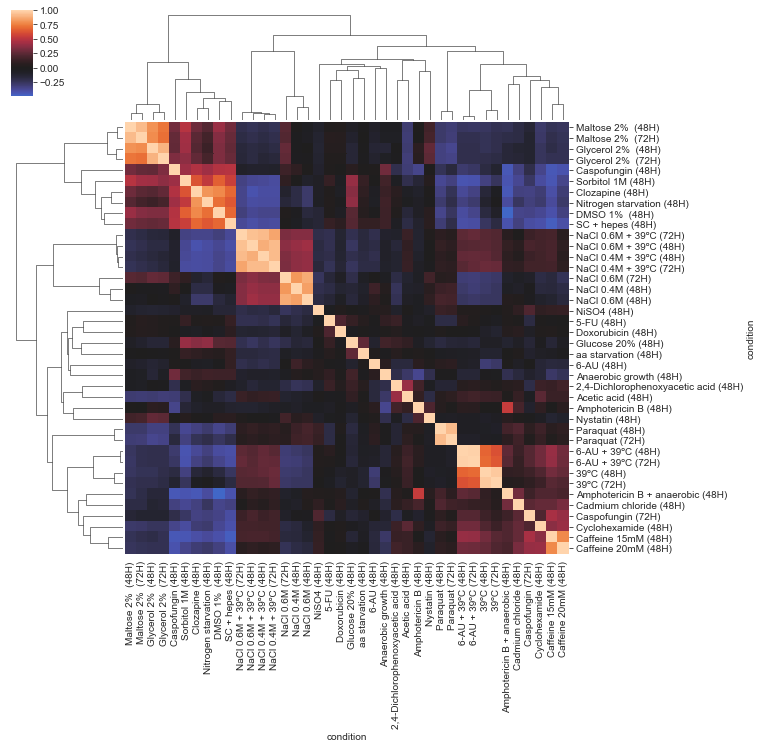

In [11]:
cc = s.pivot_table(index='gene',
                   columns='condition',
                   values='score').corr()
cm = sns.clustermap(cc,
                    center=0)
corder = cm.data2d.index;

In [12]:
clusters = {'maltose_glycerol' : ['Maltose 2%  (48H)',
                                  'Maltose 2%  (72H)',
                                  'Glycerol 2%  (48H)',
                                  'Glycerol 2%  (72H)'],
            'others': ['Clozapine (48H)',
                       'Nitrogen starvation (48H)',
                       'DMSO 1%  (48H)',
                       'SC + hepes (48H)'],
            'nacl': ['NaCl 0.6M + 39ºC (72H)',
                     'NaCl 0.6M + 39ºC (48H)',
                     'NaCl 0.4M + 39ºC (48H)',
                     'NaCl 0.4M + 39ºC (72H)',
                     'NaCl 0.6M (72H)',
                     'NaCl 0.4M (48H)',
                     'NaCl 0.6M (48H)'],
            'paraquat': ['Paraquat (48H)',
                         'Paraquat (72H)'],
            'temperature': ['6-AU + 39ºC (48H)',
                            '6-AU + 39ºC (72H)',
                            '39ºC (48H)',
                            '39ºC (72H)'],
            'caffeine': ['Caffeine 15mM (48H)',
                         'Caffeine 20mM (48H)']}

In [13]:
d = load_gene_sets(ofile, cfile,
                   pfile, kfile)

In [14]:
dev = pd.read_table(dfile, index_col=0).sort_index()

In [15]:
d['clusters'] = {}
for k in clusters:
    x = dev.loc[clusters[k]]
    genes = x[(x['qvalue'] < 1E-2) &
              ((x['strain1'] == 'S288C') | (x['strain2'] == 'S288C')) &
              (x['phenotype1'] != x['phenotype2'])].groupby('gene')['qvalue'].min().sort_values().head(15).index
    d['clusters'][k] = set(genes)
d['clusters2'] = {}
for k in clusters:
    x = dev.loc[clusters[k]]
    genes = x[(x['qvalue'] < 1E-2) &
              ((x['strain1'] != 'S288C') & (x['strain2'] != 'S288C')) &
              (x['phenotype1'] != x['phenotype2'])].groupby('gene')['qvalue'].min().sort_values().head(15).index
    d['clusters2'][k] = set(genes)

In [16]:
strains = {'UWOPS03-461.4': 'UWOP',
           'Y55': 'Y55'}
rstrains = {'UWOPS03-461.4': 'UWOP',
            'YPS606': 'YPS'}

In [17]:
r = []
for fname, strain in zip([os.path.join(rdir, x)
                          for x in ['UWOPS87_2421.csv',
                                    'Y55.csv',
                                    'YPS606.csv']],
                         ['UWOP', 'Y55', 'YPS']):
    df = read_de_table(fname)
    df['strain'] = strain
    df.index = [gn.get(x, x) for x in df.index]
    df.index.name = 'gene'
    r.append(df)
r = pd.concat(r)
r = r.reset_index().set_index(['strain', 'gene']).sort_index()

In [18]:
t = pd.read_table(tfile)

In [19]:
# g = pd.read_table(gfile, index_col=0)
# g[np.isnan(g)] = 0.0
# g = g.loc[strains].rename(index=strains)
# g = g.T.loc[g.sum()[g.sum() != 0].index].T

In [20]:
# m = pd.read_table(mfile).set_index('snpID')
# m = m.loc[m.index.intersection(g.columns)]

In [21]:
d['custom'] = {}
d['custom']['MAL'] = {k for k, v in gn.items() if v.startswith('MAL')}
nacl = s.loc[(slice(None), slice(None), sorted({x[-1] for x in s.index
                                                if x[-1].startswith('NaCl')})),]
d['custom']['osmotic'] = {x[1] for x in nacl[nacl['qvalue'] <= 1E-8].index}
nacl = s.loc[(slice(None), slice(None), sorted({x[-1] for x in s.index
                                                if x[-1].startswith('Maltose')})),]
sn = nacl.reset_index().groupby(['gene'])['strain'].nunique()
mgenes = sn[sn == 4].index
nacl = nacl.loc[(slice(None), mgenes),]
d['custom']['maltose'] = {x[1] for x in nacl[nacl['qvalue'] <= 1E-20].index}

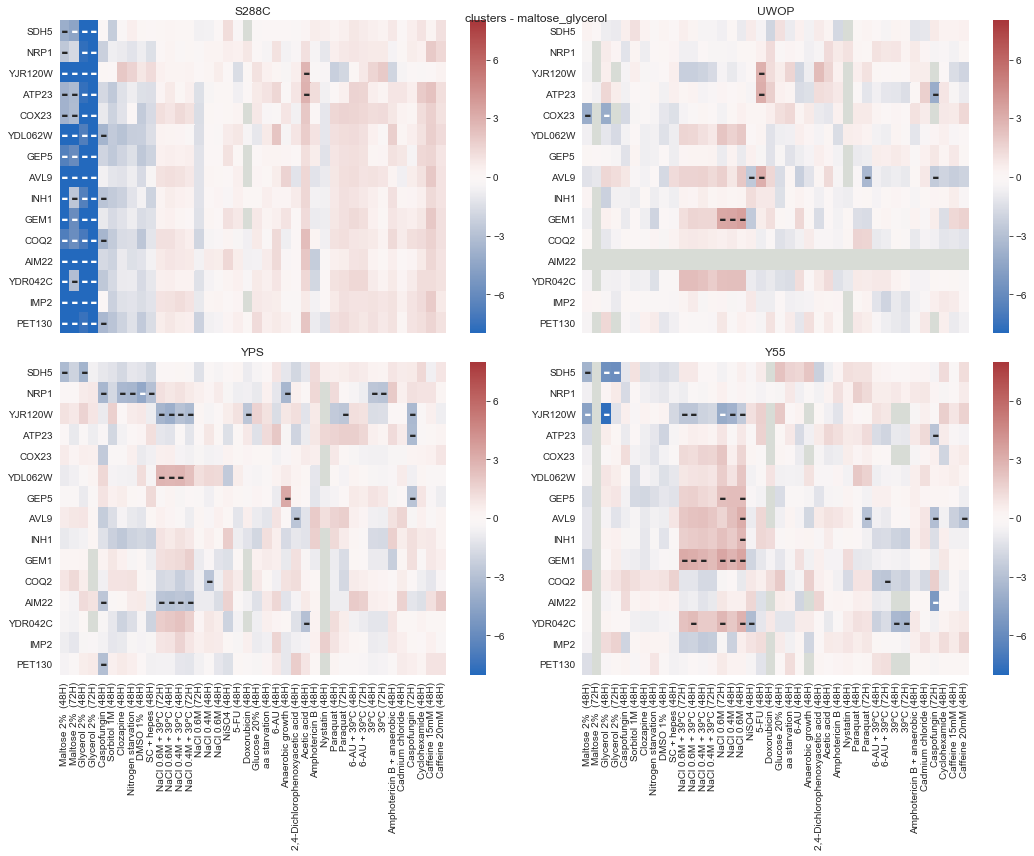

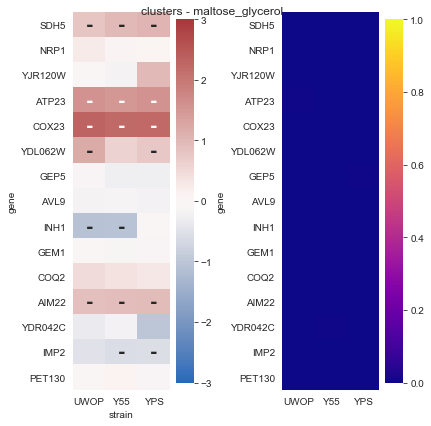

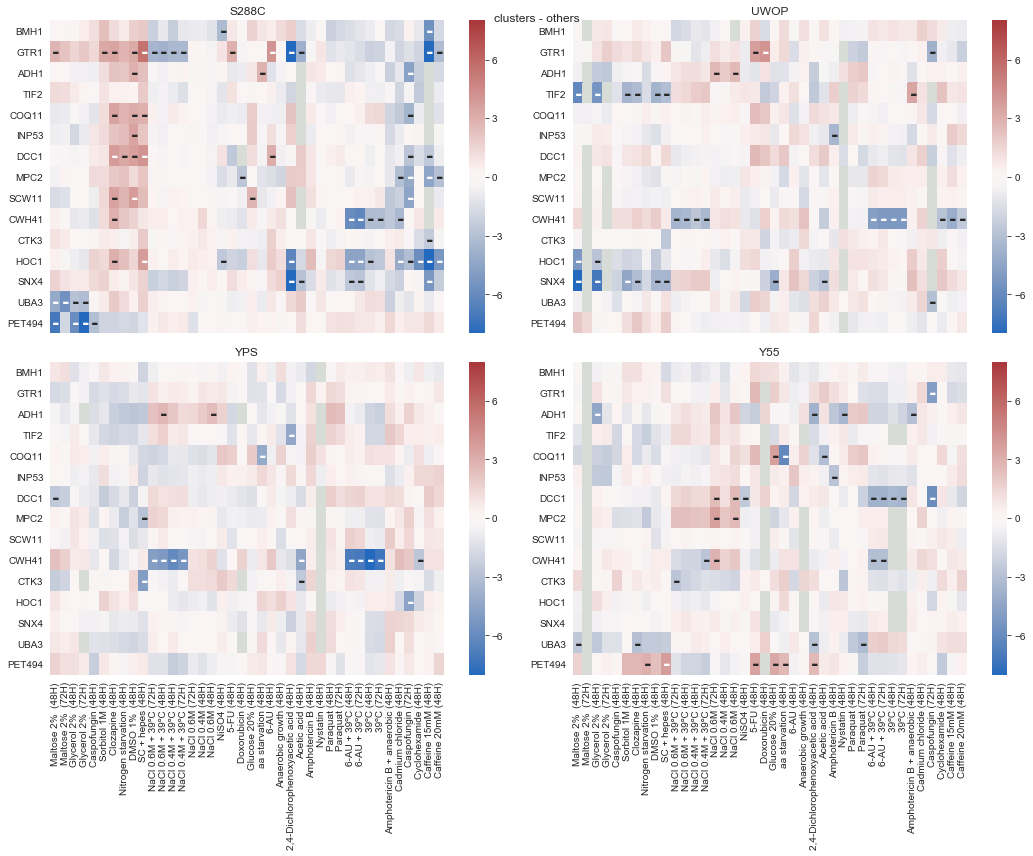

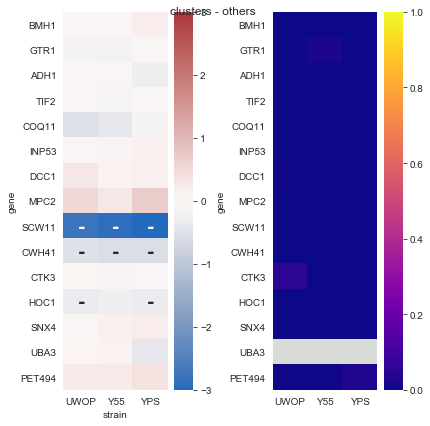

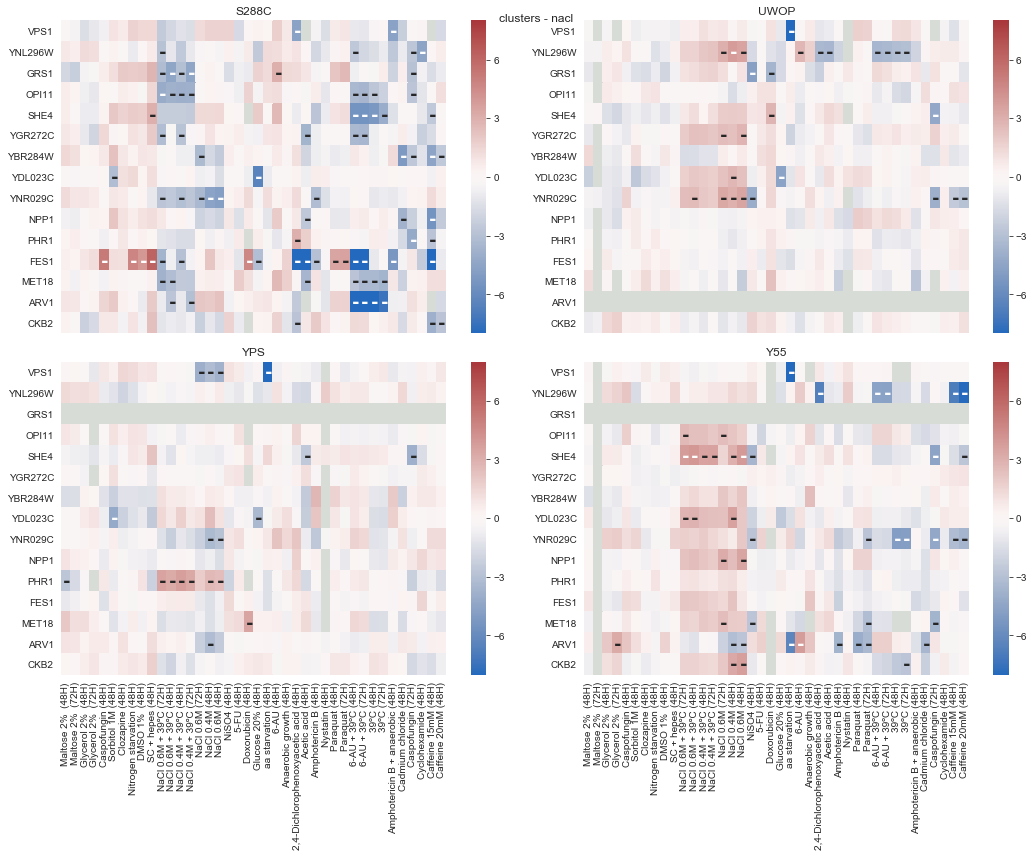

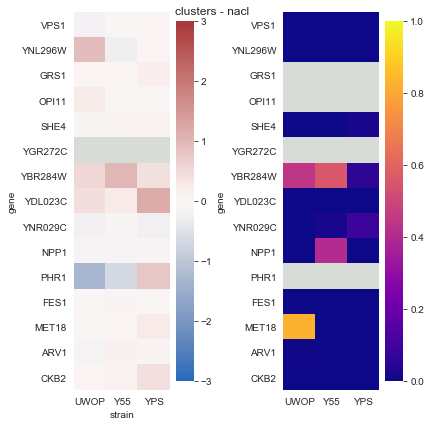

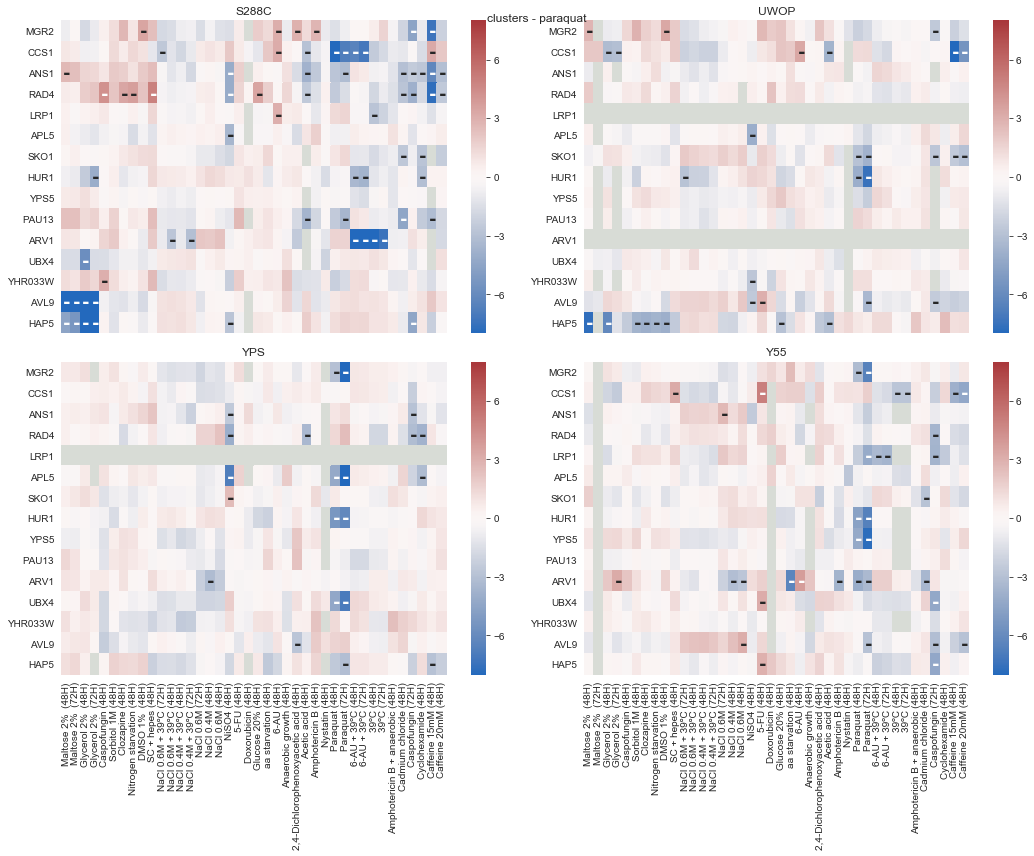

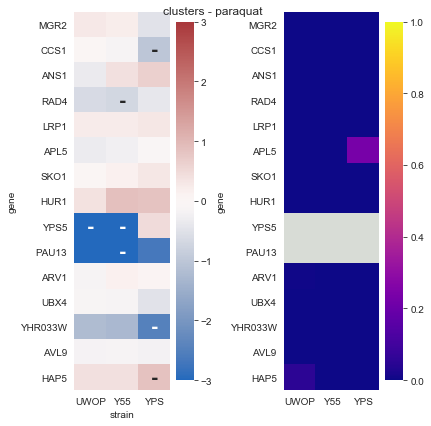

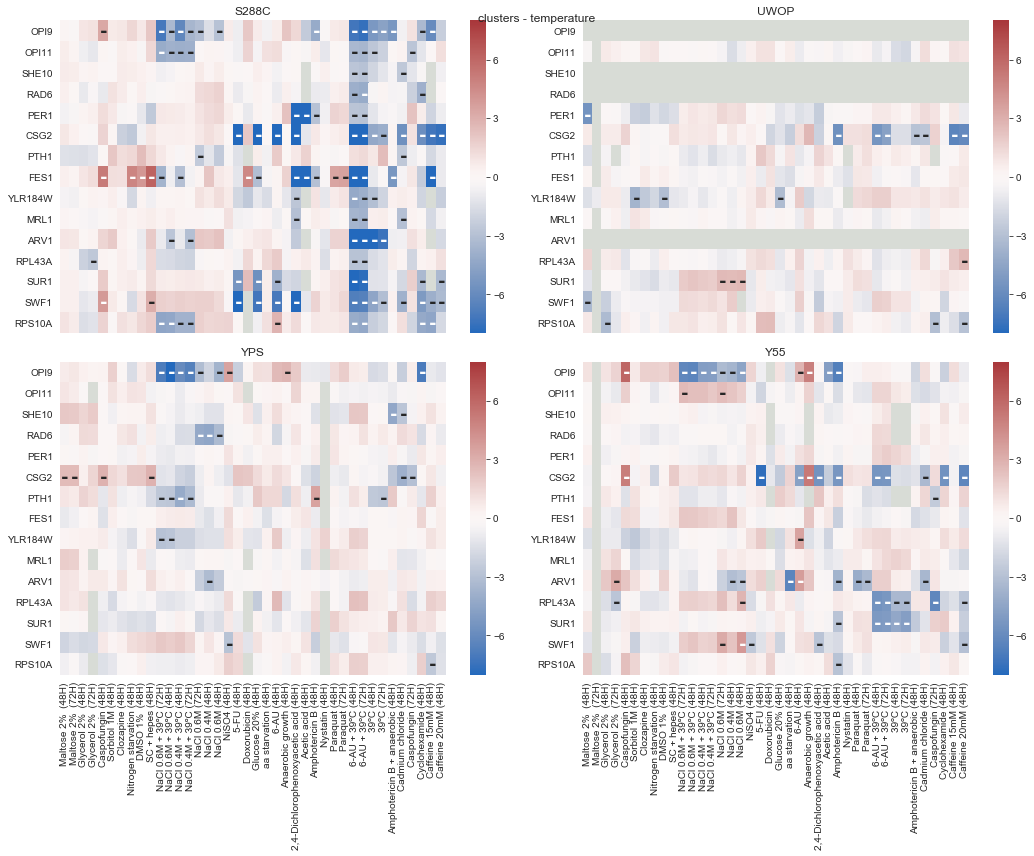

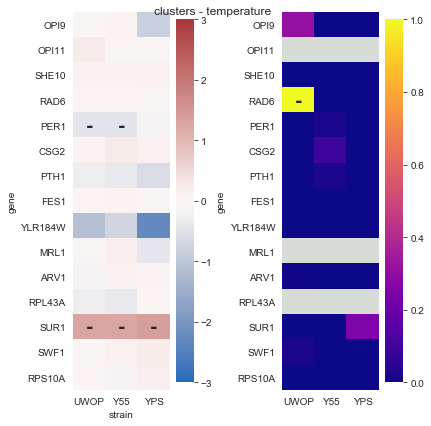

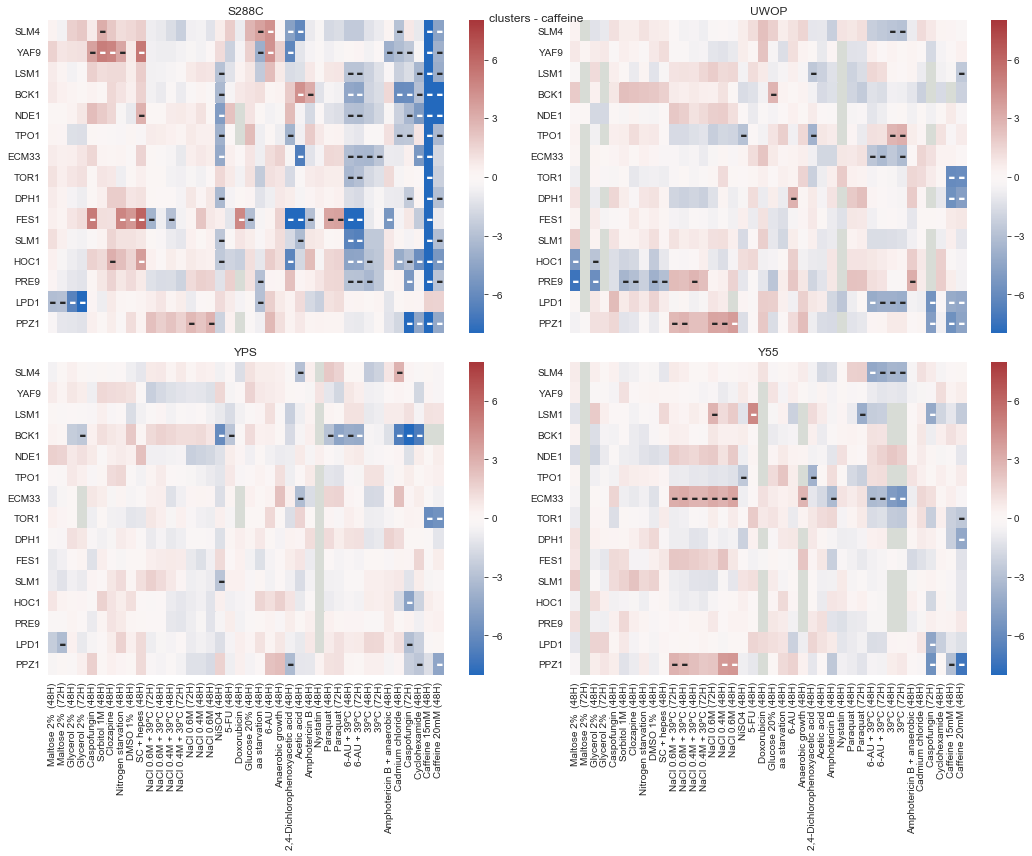

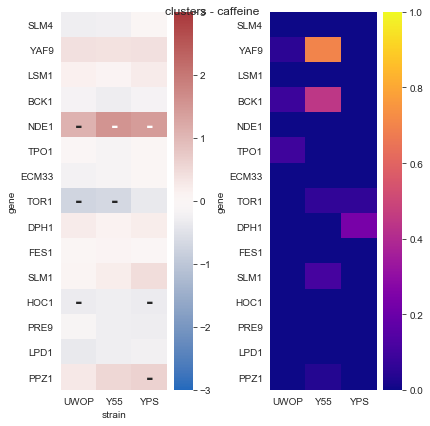

In [22]:
!mkdir -p clusters
!mkdir -p clusters_expression

cat = 'clusters'
for name in d[cat]:
    gorder = plot_scores(d, s, cat, name, corder=corder)
    plt.savefig('clusters/%s_%s.png' % (cat, name), dpi=150)
    plot_extra(r, paf, gorder, cat, name)
    plt.savefig('clusters_expression/%s_%s.png' % (cat, name), dpi=150)

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


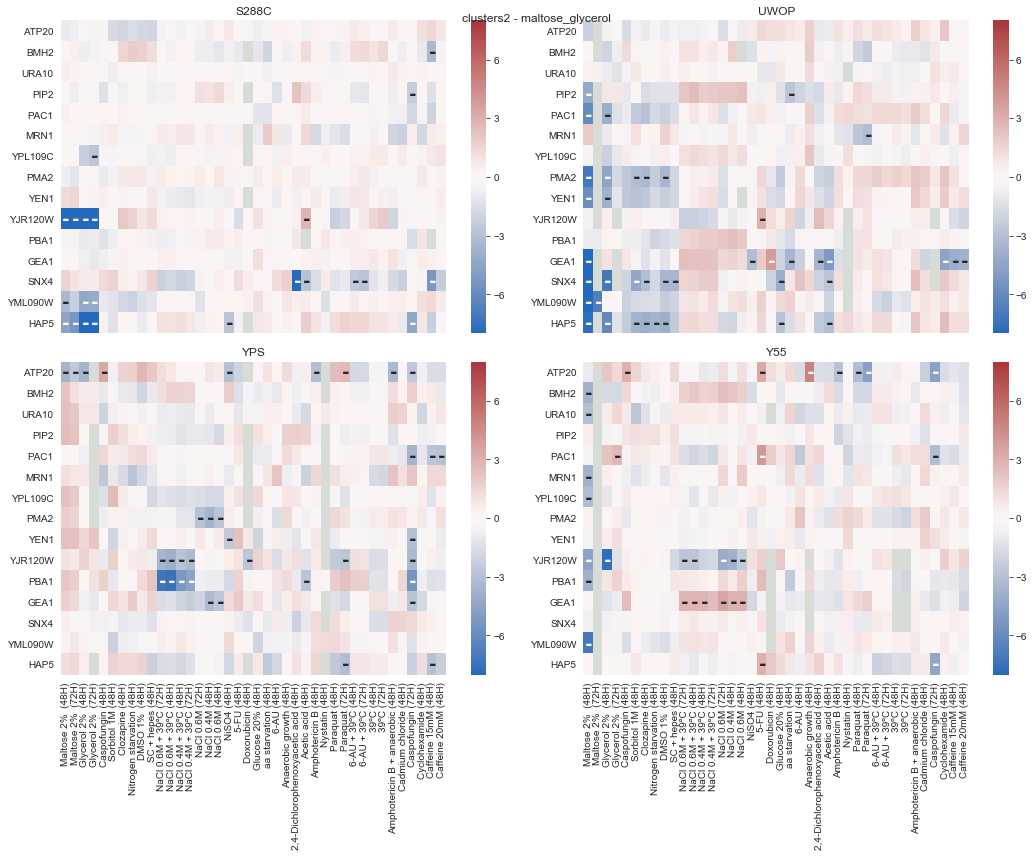

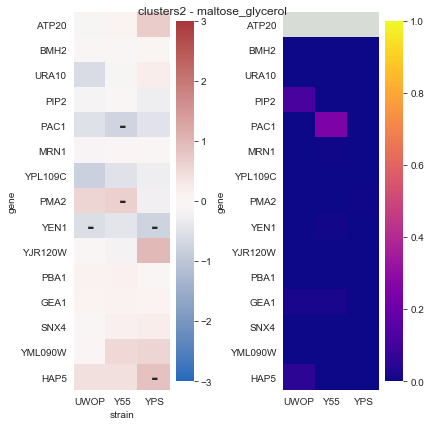

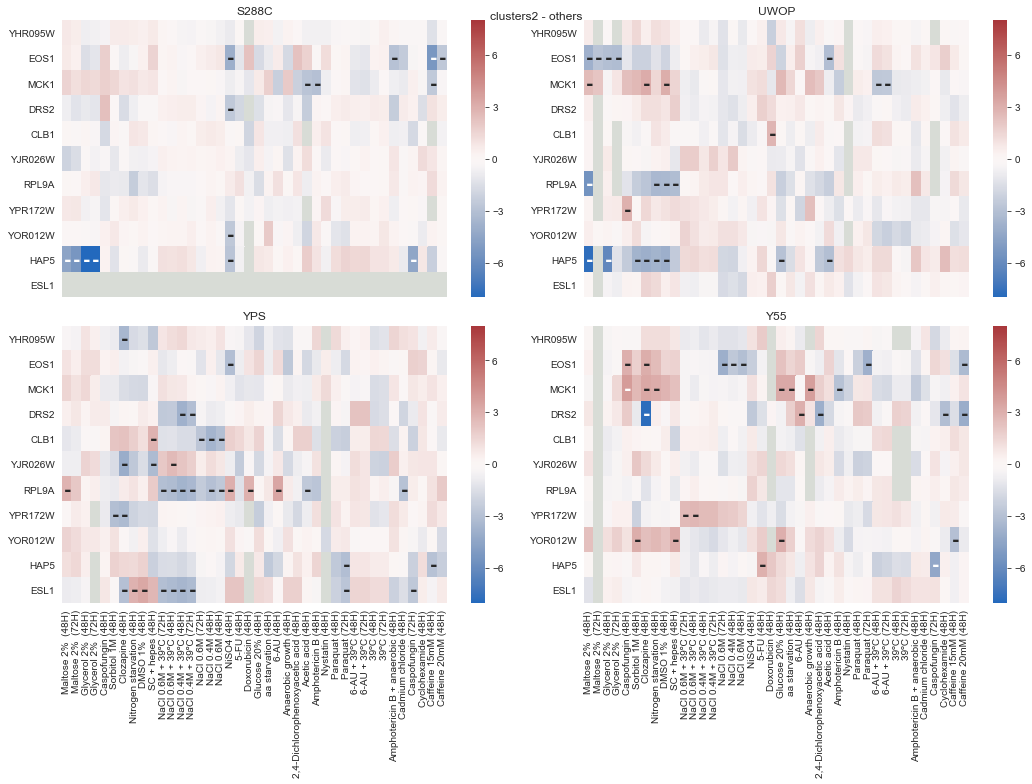

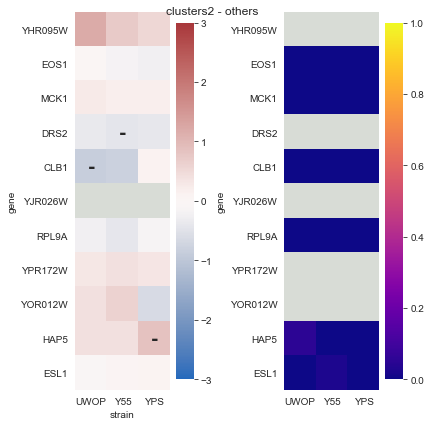

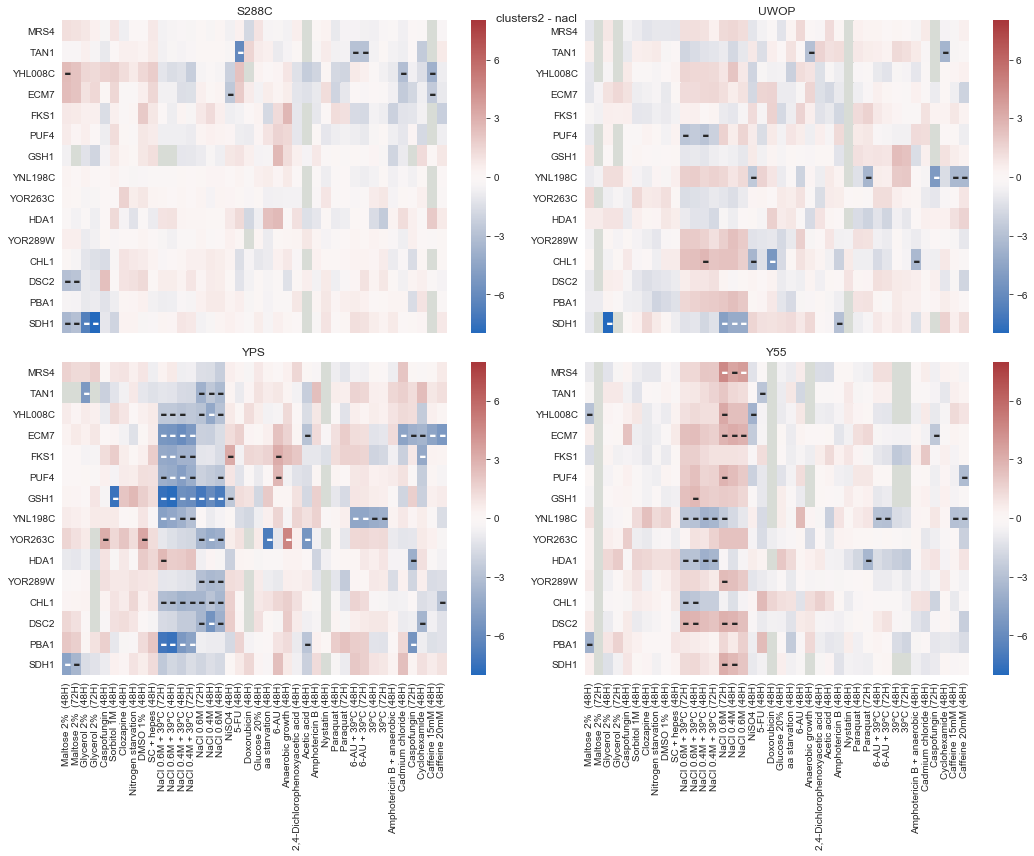

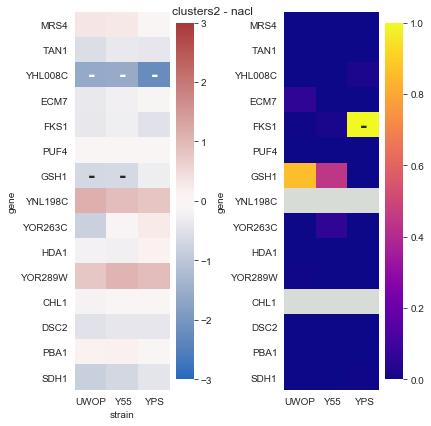

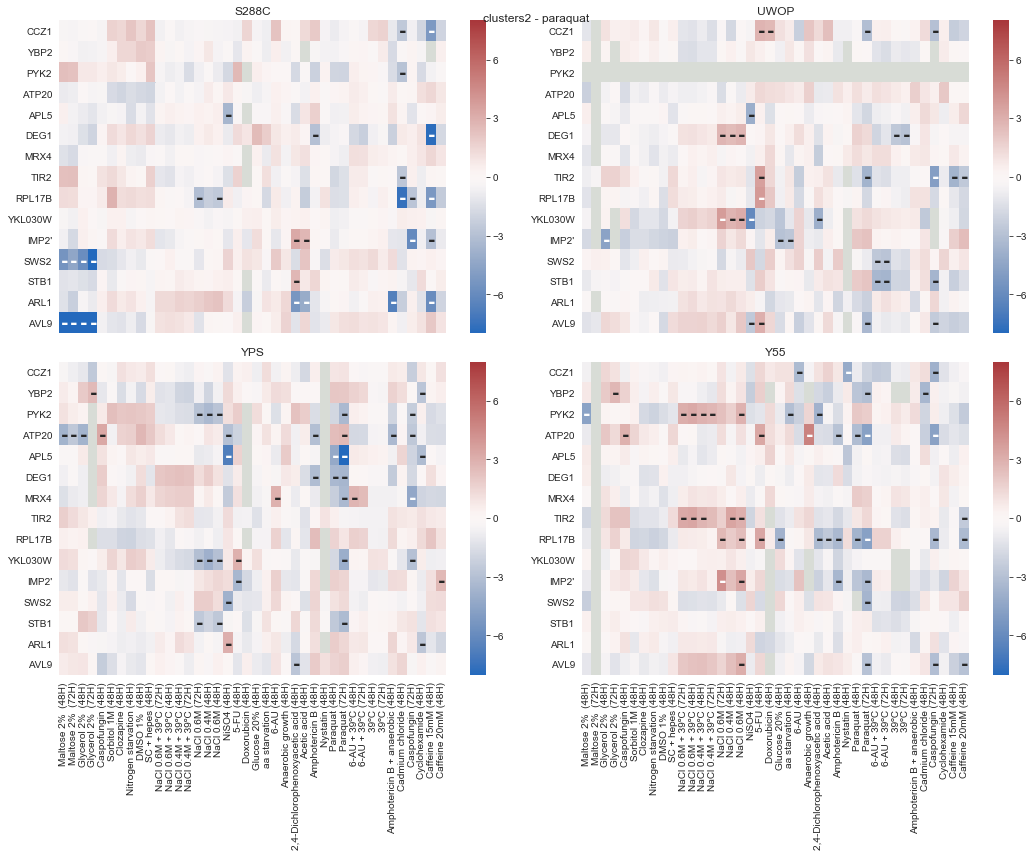

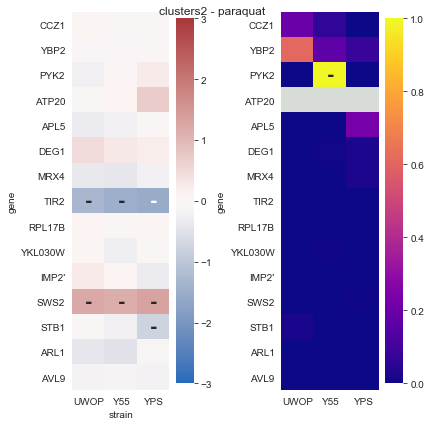

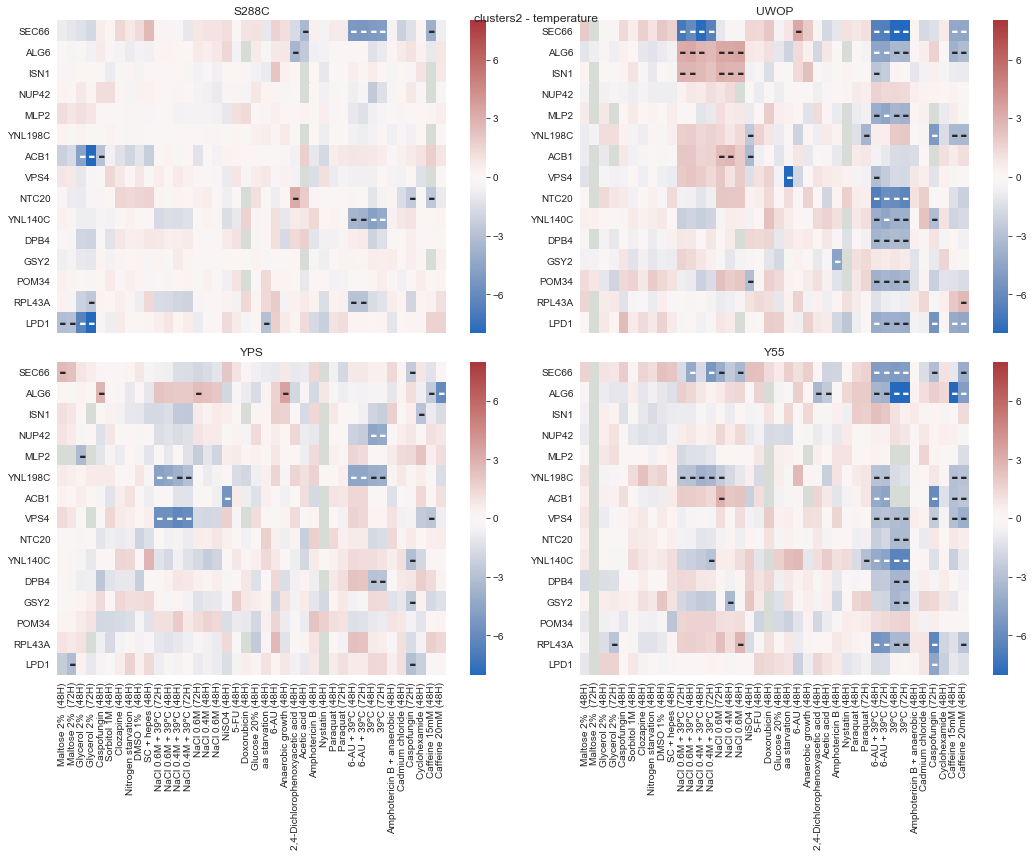

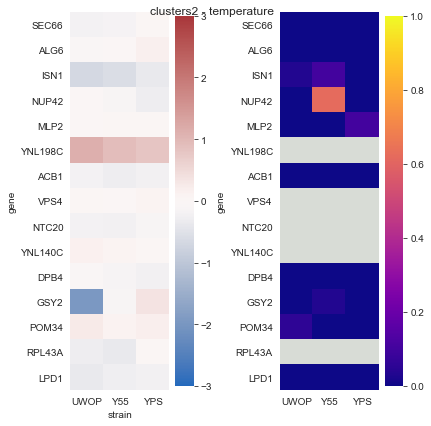

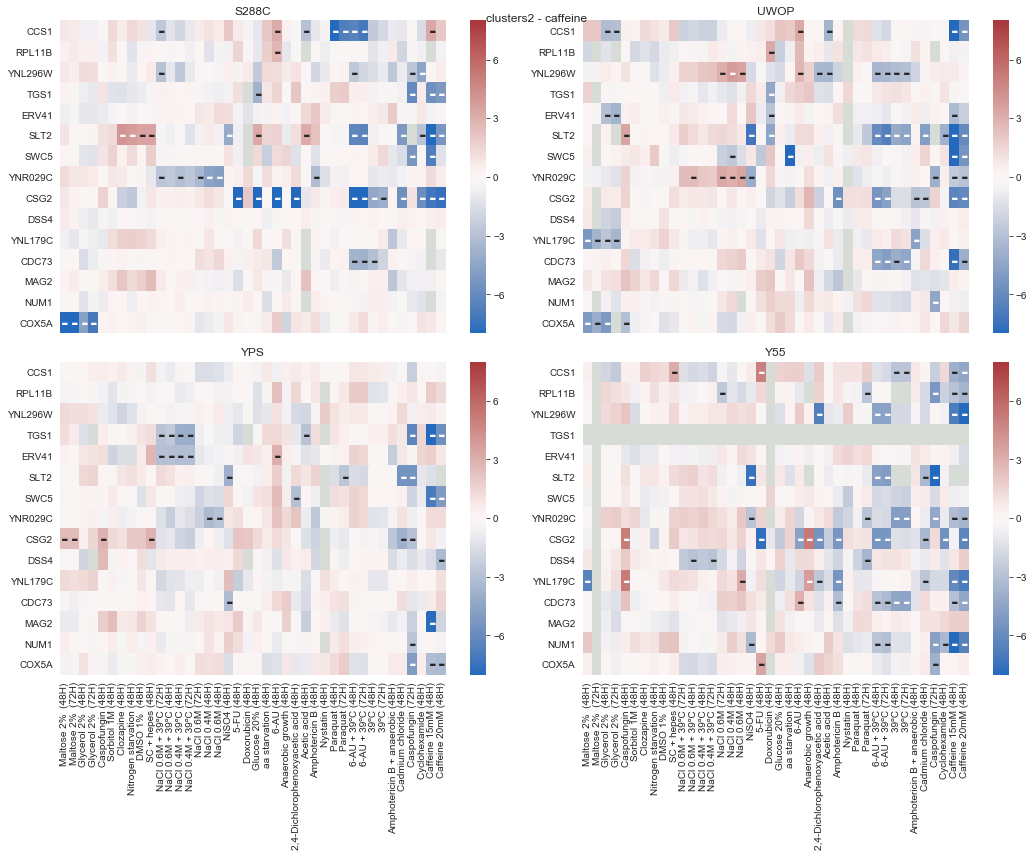

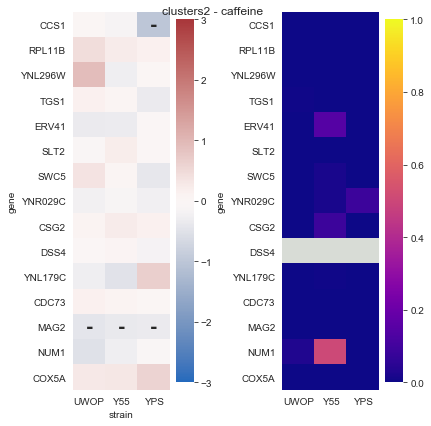

In [23]:
!mkdir -p clusters2
!mkdir -p clusters2_expression

cat = 'clusters2'
for name in d[cat]:
    gorder = plot_scores(d, s, cat, name, corder=corder)
    plt.savefig('clusters2/%s_%s.png' % (cat, name), dpi=150)
    plot_extra(r, paf, gorder, cat, name)
    plt.savefig('clusters2_expression/%s_%s.png' % (cat, name), dpi=150)

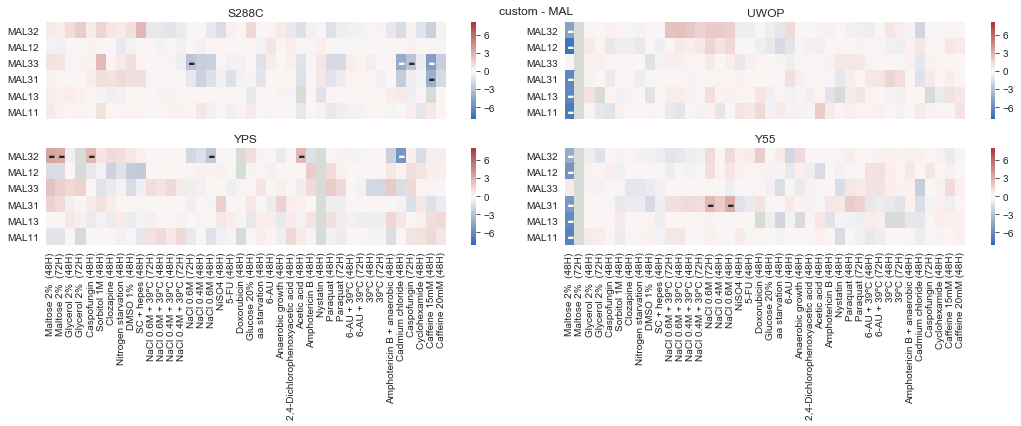

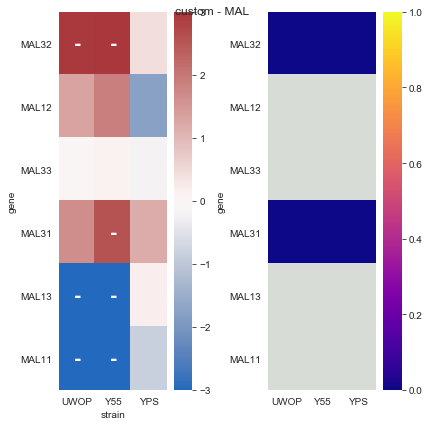

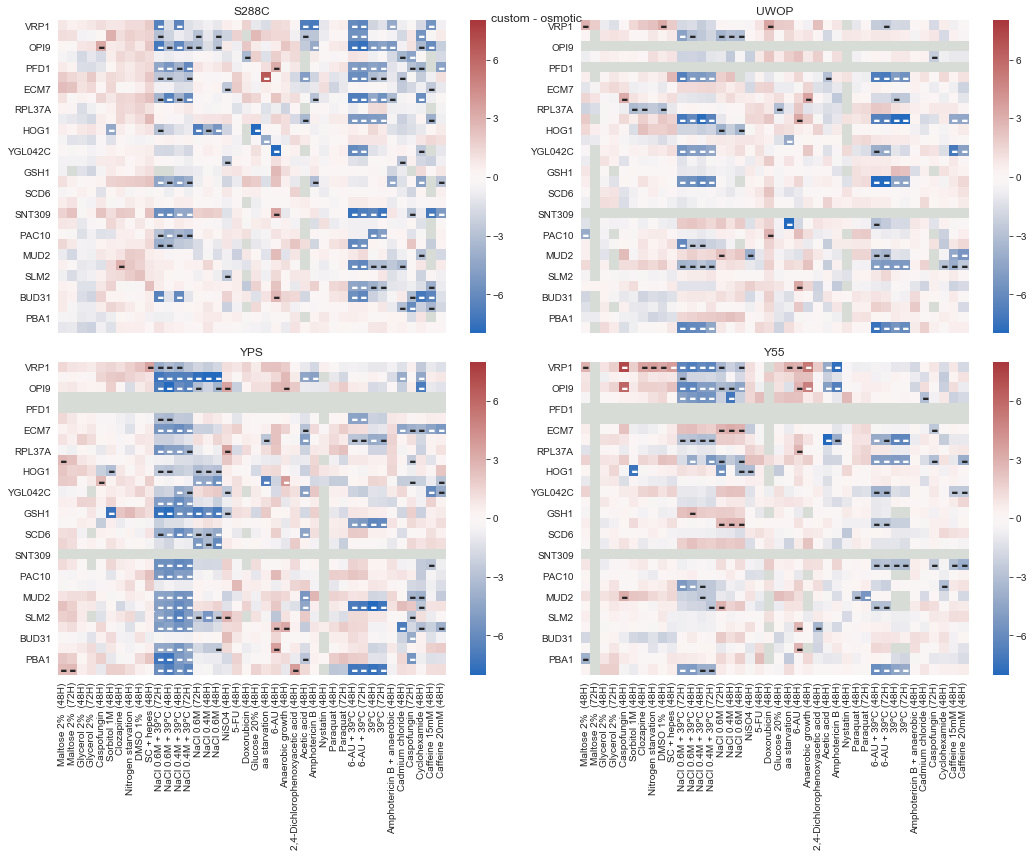

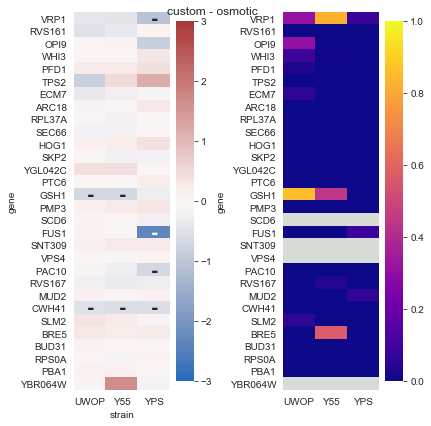

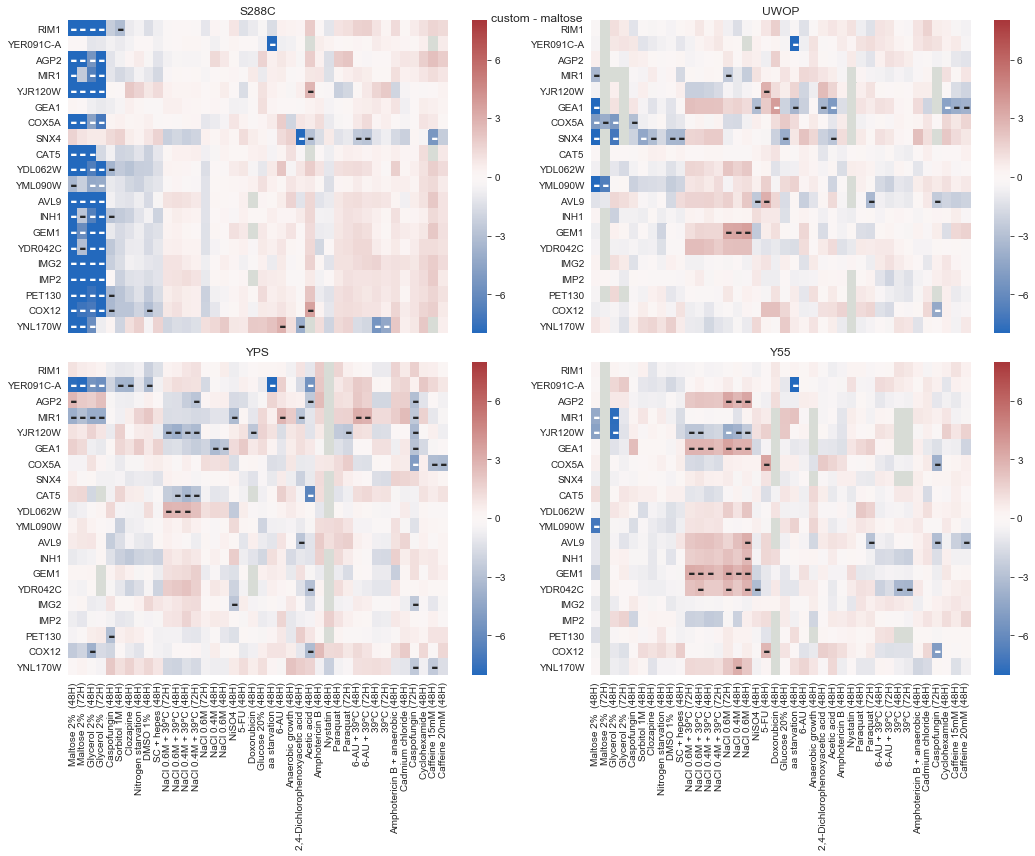

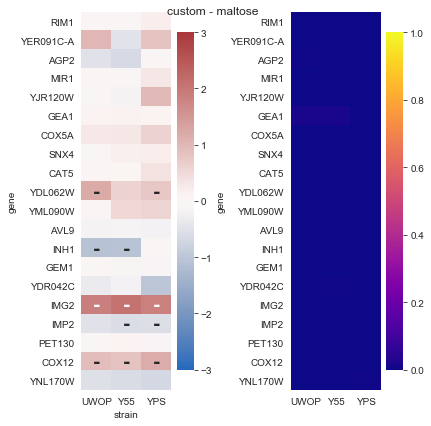

In [24]:
!mkdir -p custom
!mkdir -p custom_expression

cat = 'custom'
for name in d[cat]:
    gorder = plot_scores(d, s, cat, name, corder=corder)
    plt.savefig('custom/%s_%s.png' % (cat, name), dpi=150)
    plot_extra(r, paf, gorder, cat, name)
    plt.savefig('custom_expression/%s_%s.png' % (cat, name), dpi=150)

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


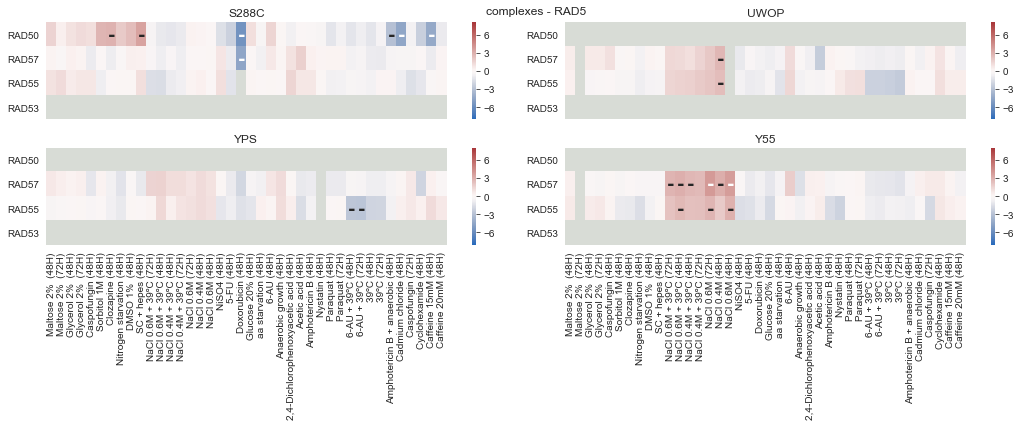

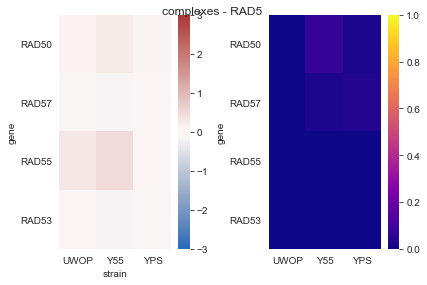

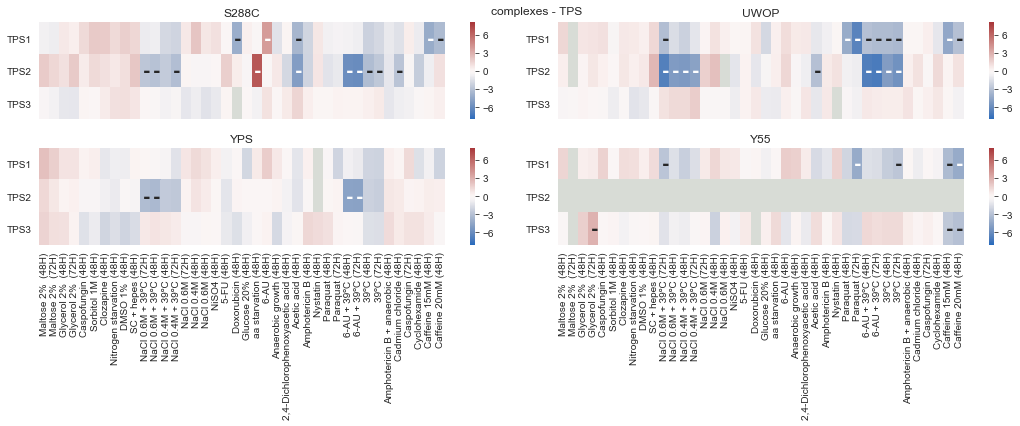

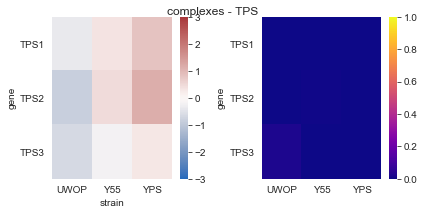

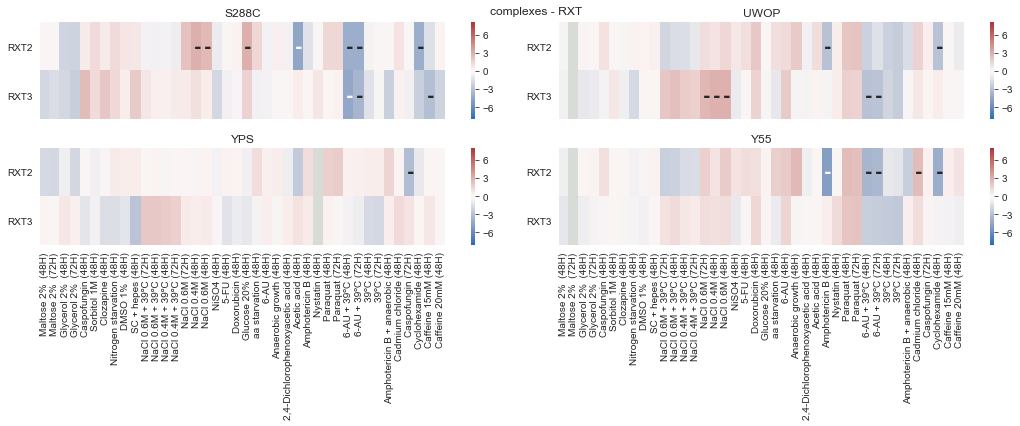

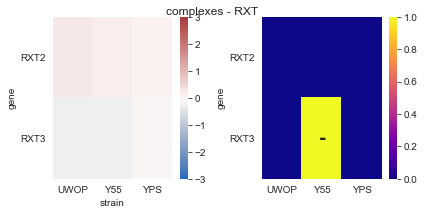

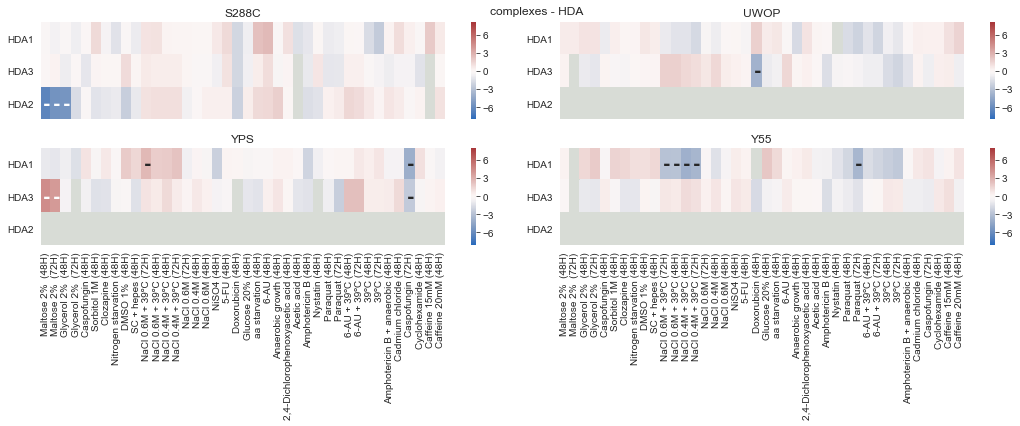

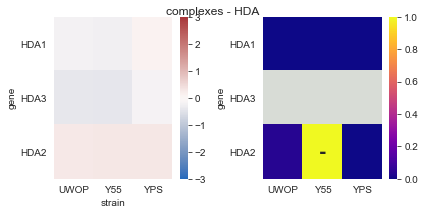

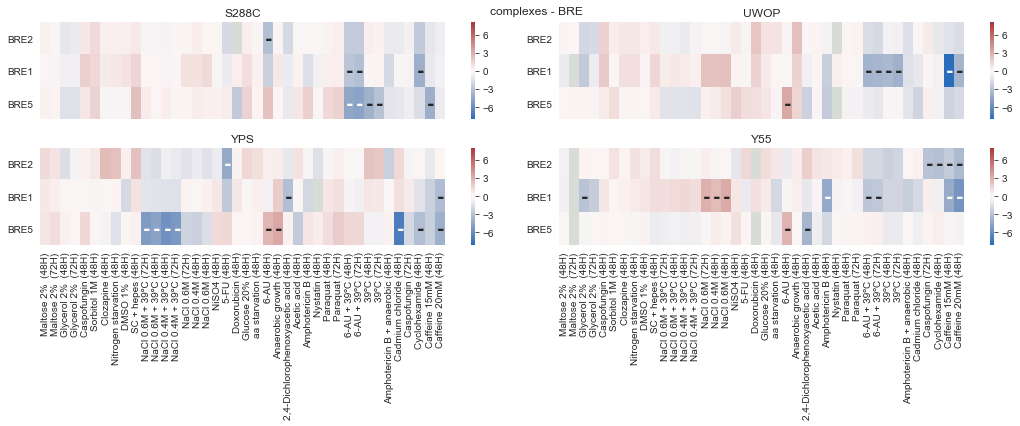

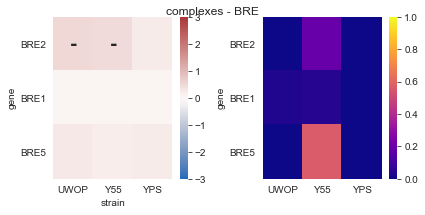

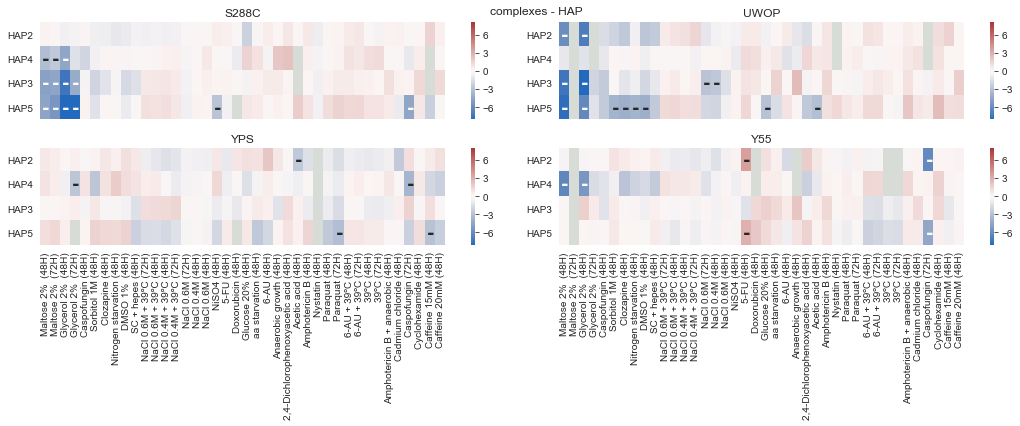

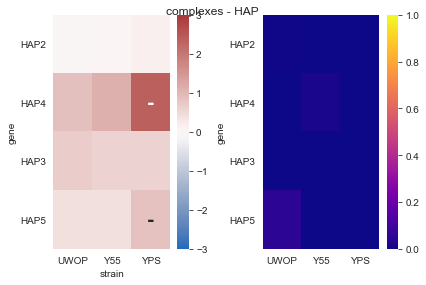

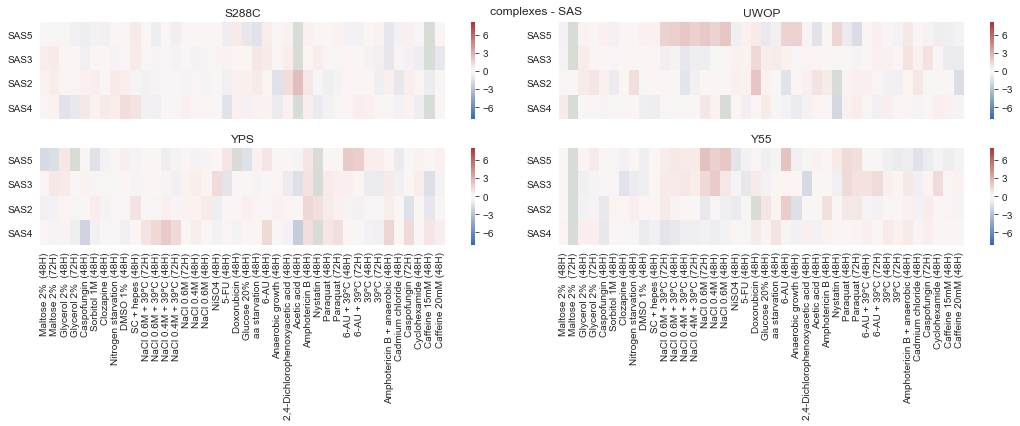

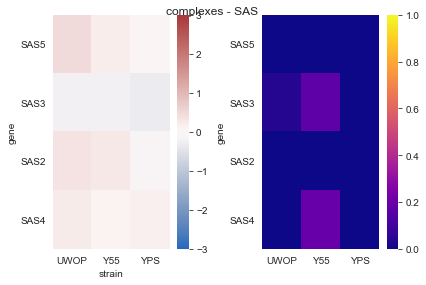

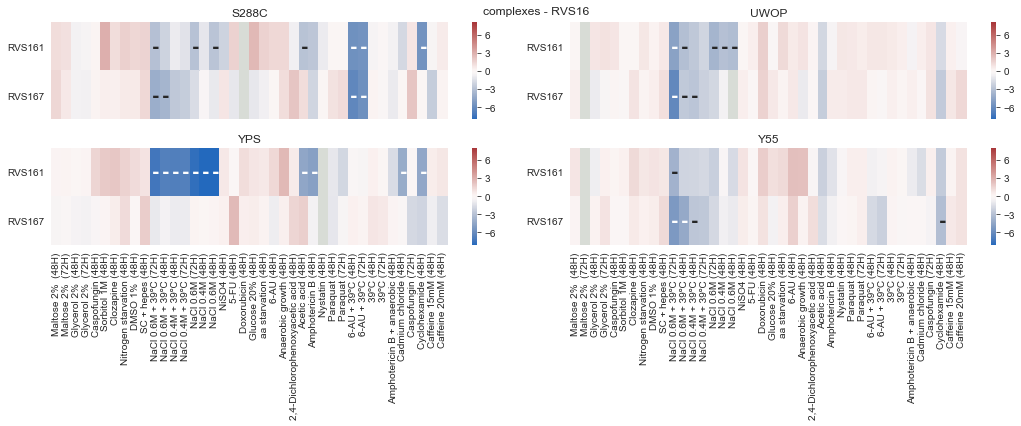

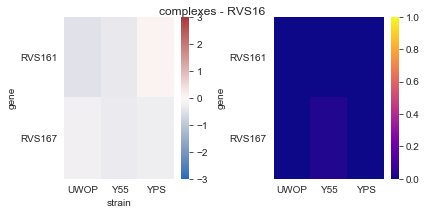

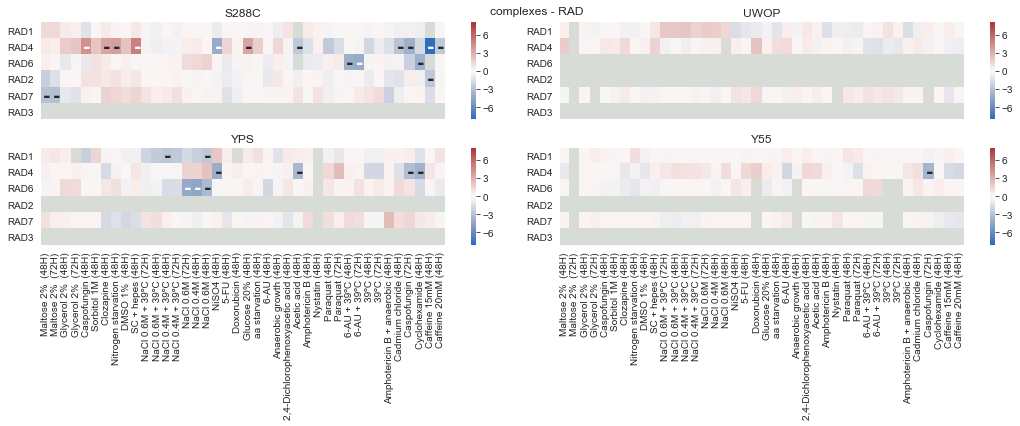

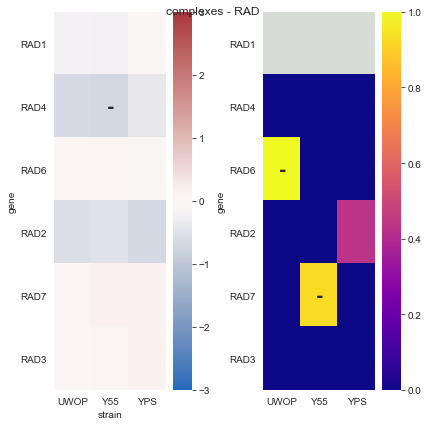

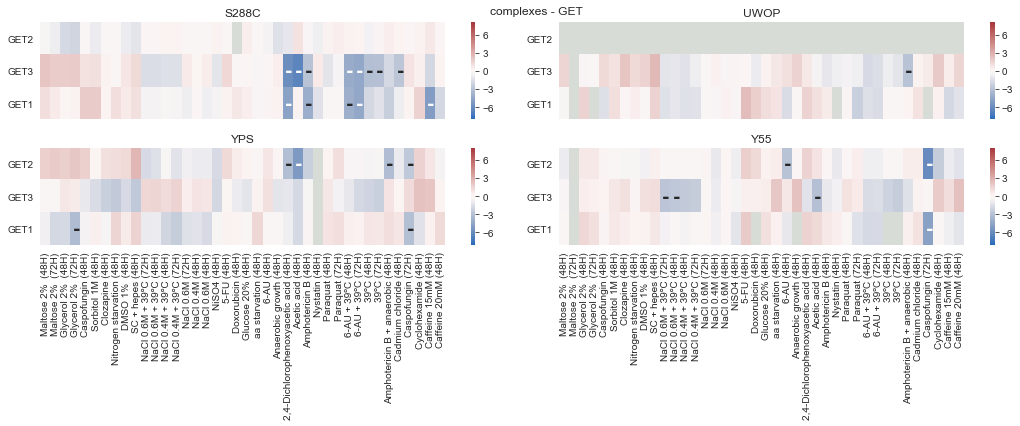

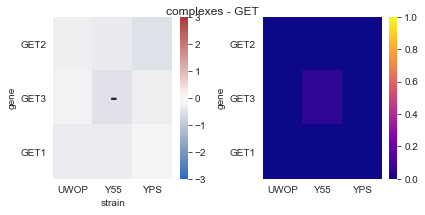

In [25]:
!mkdir -p complexes
!mkdir -p complexes_expression

for cat, name in t[(t['test'] == 'anderson') &
                   (t['category'] == 'complexes') &
                   (t['qval'] <= 0.01)].groupby(['category',
                   'name'])['qval'].min().sort_values().head(10).index:
    gorder = plot_scores(d, s, cat, name, corder=corder)
    plt.savefig('complexes/%s_%s.png' % (cat, name), dpi=150)
    plot_extra(r, paf, gorder, cat, name)
    plt.savefig('complexes_expression/%s_%s.png' % (cat, name), dpi=150)

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


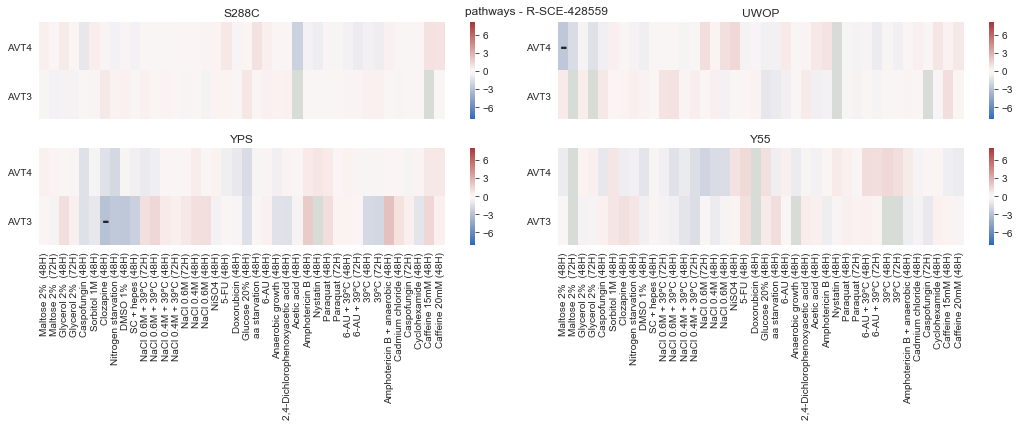

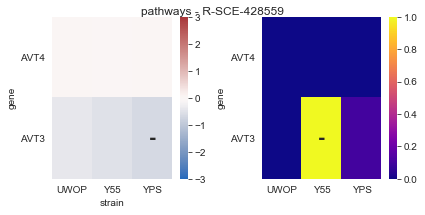

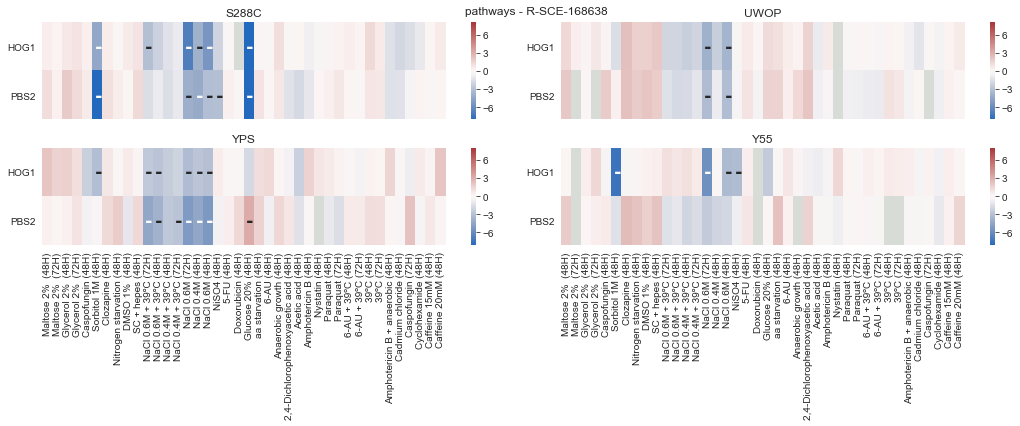

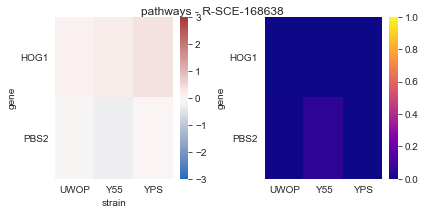

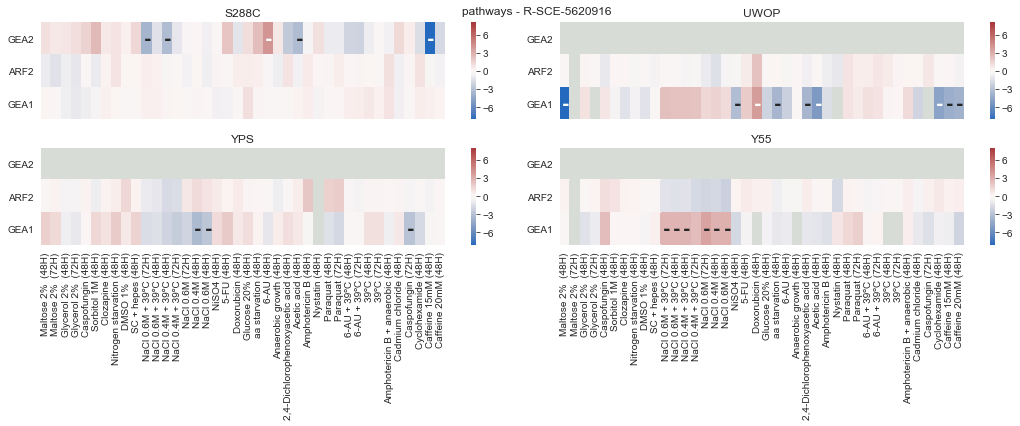

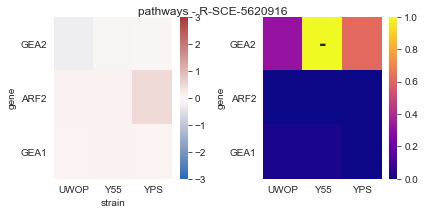

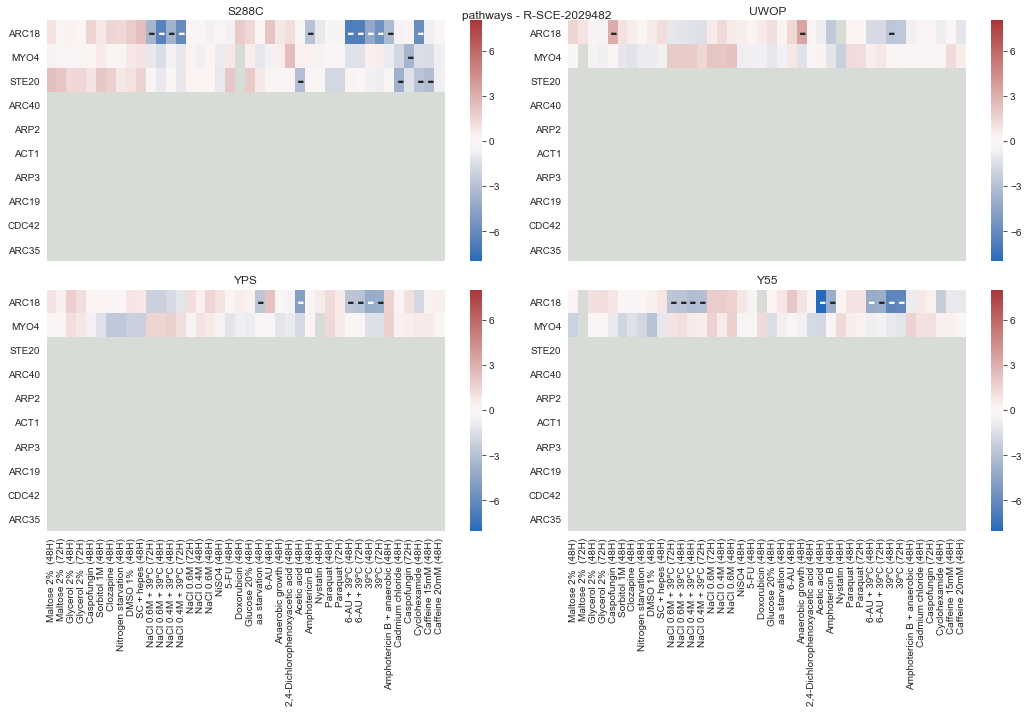

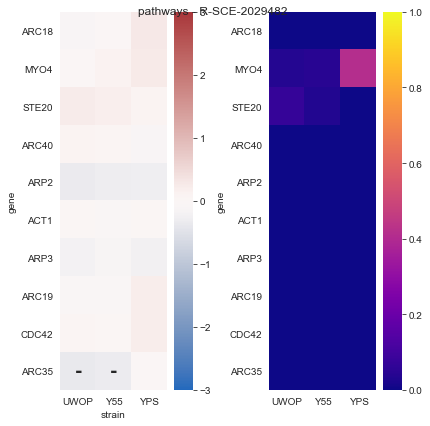

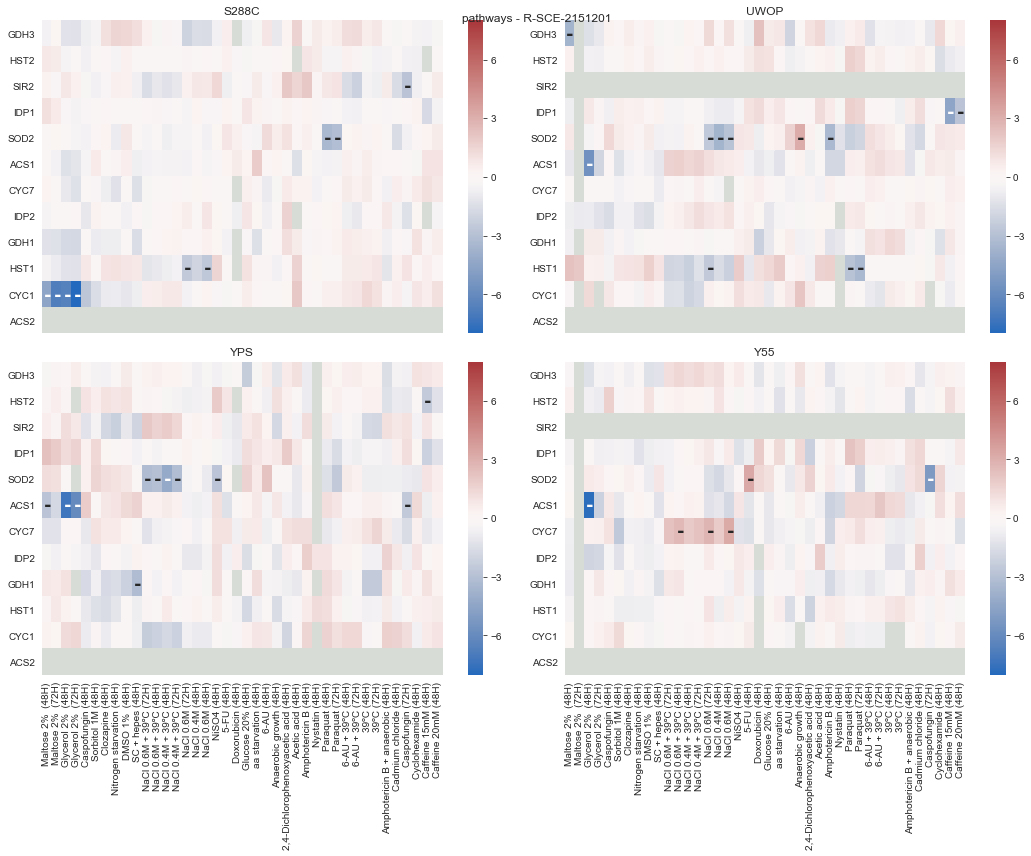

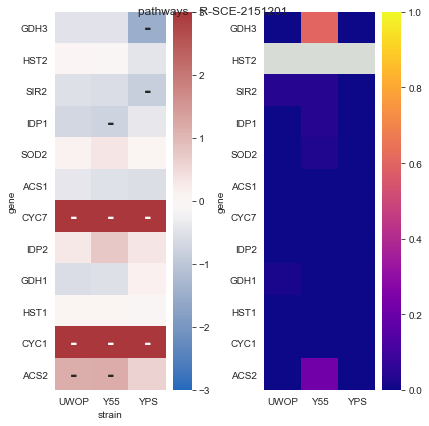

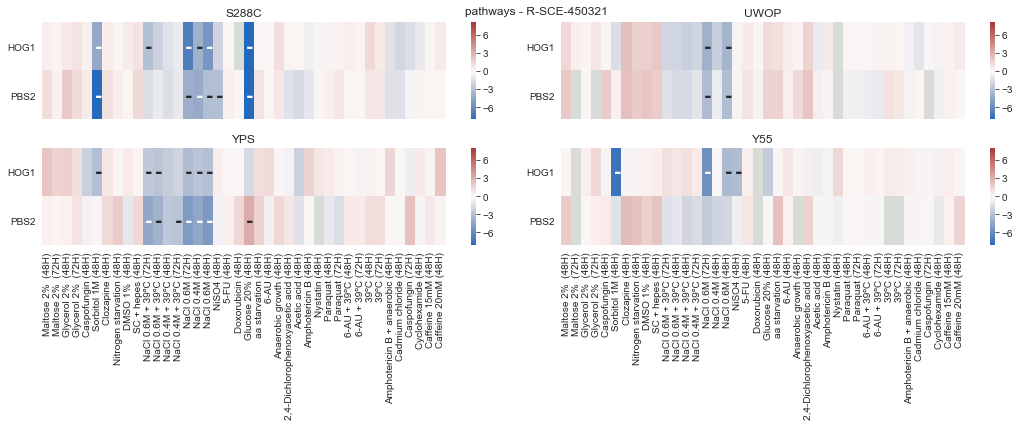

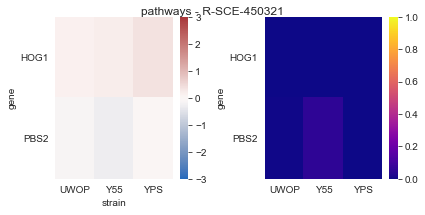

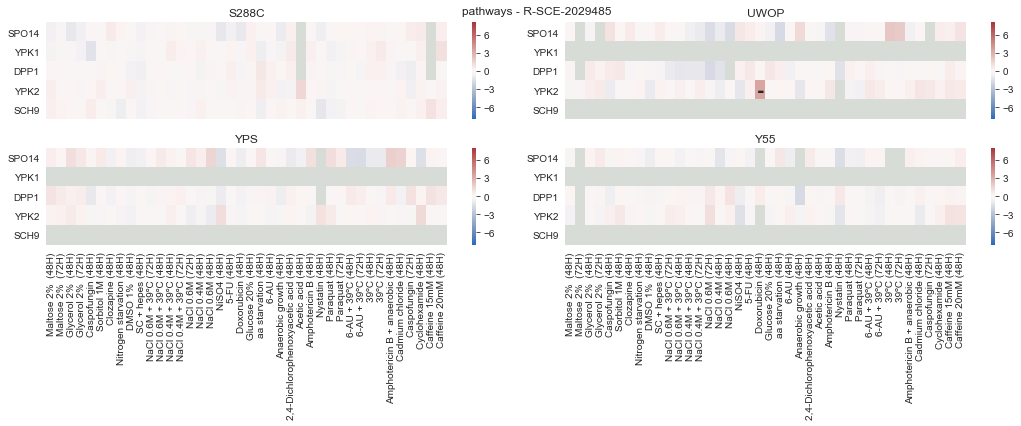

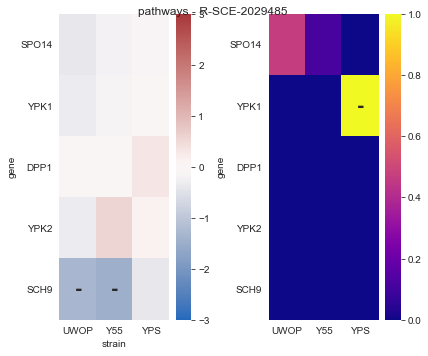

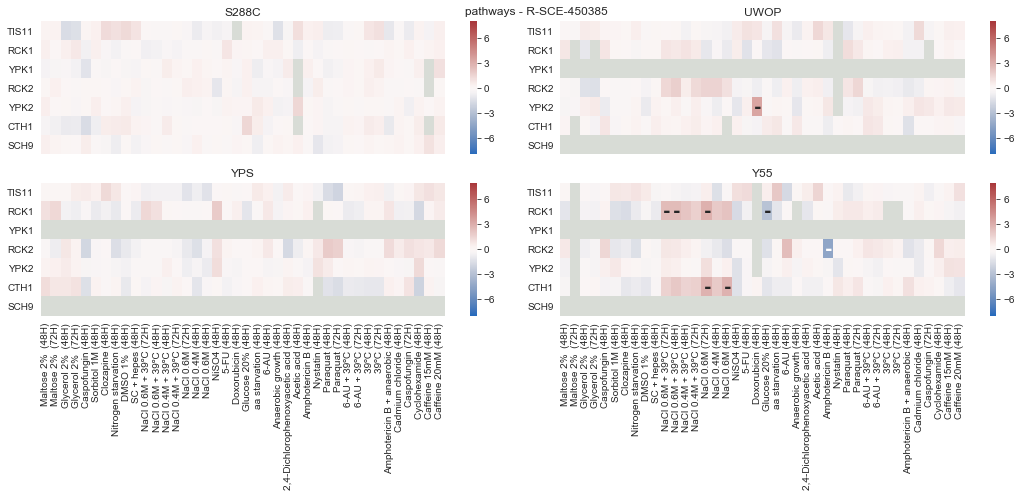

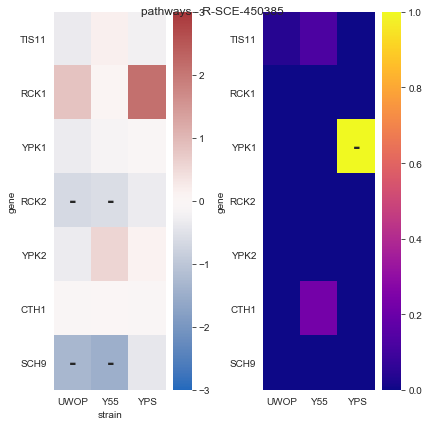

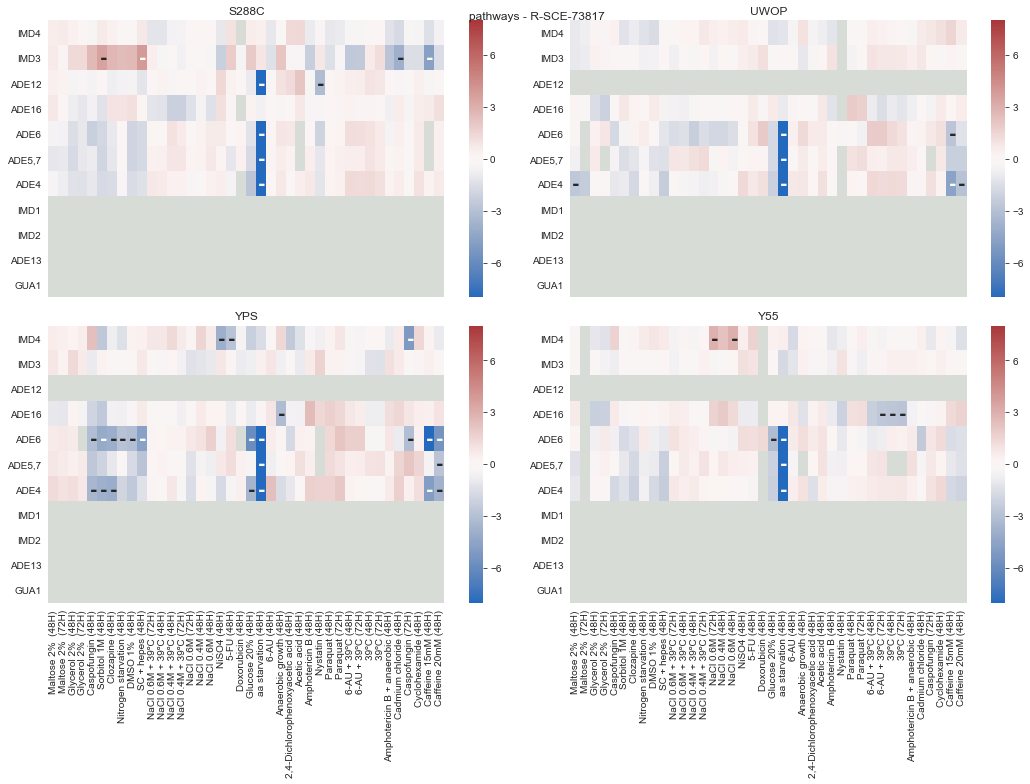

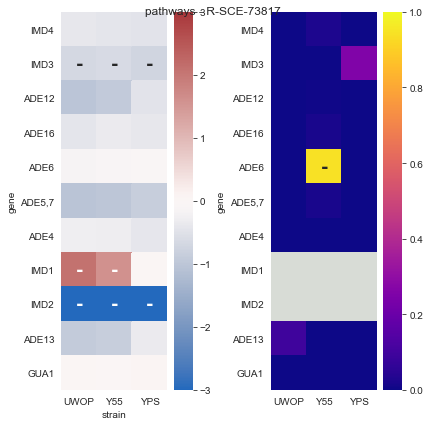

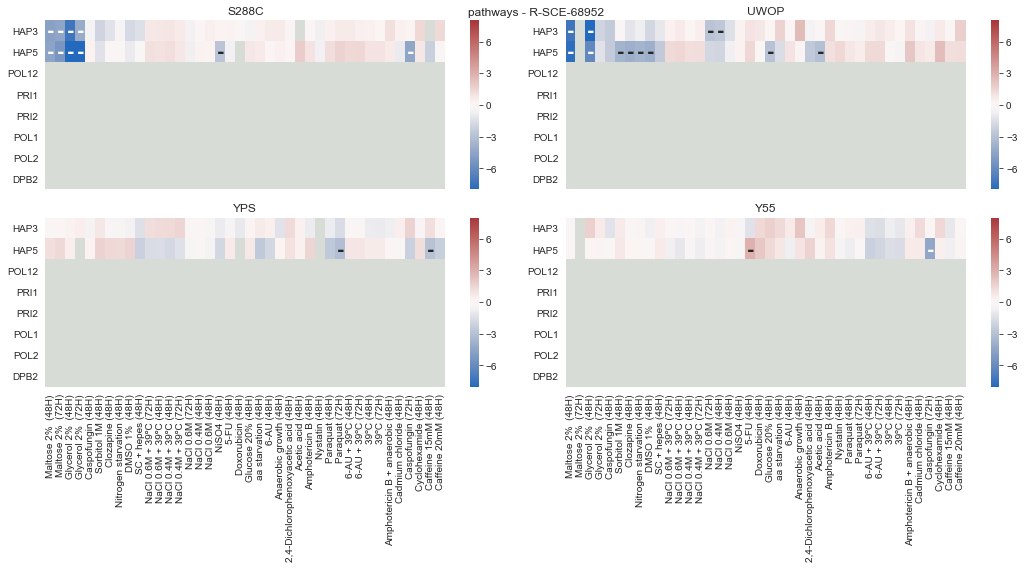

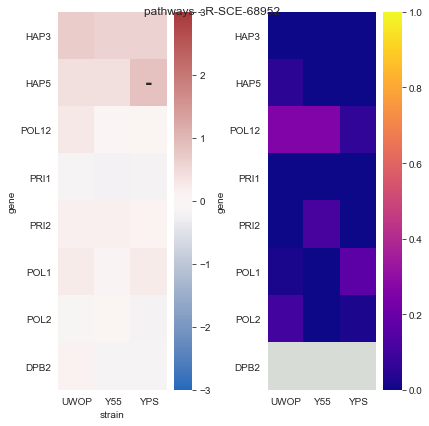

In [26]:
!mkdir -p pathways
!mkdir -p pathways_expression

for cat, name in t[(t['test'] == 'anderson') &
                   (t['category'] == 'pathways') &
                   (t['qval'] <= 0.01)].groupby(['category',
                   'name'])['qval'].min().sort_values().head(10).index:
    gorder = plot_scores(d, s, cat, name, corder=corder)
    plt.savefig('pathways/%s_%s.png' % (cat, name), dpi=150)
    plot_extra(r, paf, gorder, cat, name)
    plt.savefig('pathways_expression/%s_%s.png' % (cat, name), dpi=150)

In [28]:
len(s.reset_index()['condition'].unique())

40

In [29]:
len(s.reset_index()['gene'].unique())

4899